## Practical work in AI

1. Image preprocessing

The images are not sorted in the right way: can't figure out which domain belongs to which images.
I wrote a script to perform sorting based on the domain names that are present in the UNPROCESSED Retouch images.
Now, I have a list of dicts for the source images and a list of dicts for the target images.

2. Image augmentation

    Main problem currently: SVD is slow (0.6 seconds/image just for the decomposition!)
    the entire dataset in batches of 16, dataloading alone takes more than 5 minutes!

    

3. Training

    How many output channels does my network? 2? How many classes do I actually have? i guess 3, since in the paper they use 3 biomarkers
       

In [4]:
import numpy as np

from pathlib import Path
import os
from typing import *

from tqdm.notebook import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import monai
from monai.networks.nets import BasicUNetPlusPlus
from monai.transforms import *
from monai.config.type_definitions import KeysCollection

import albumentations as A

import wandb

# Imports from local files
from transforms import *
from dataset import OCTDatasetPrep, MakeDataset
from utils import *


# Set random seed
np.random.seed(99)
torch.manual_seed(99)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


True

## Paths to the data

In [5]:
class Config():

    def __init__(self):

        # paths
        # directory where img folders are still sorted by domain (but unprocessed OCT images)
        self.name_dir = Path(Path.cwd() / 'data/RETOUCH/TrainingSet-Release/') 
        # already processed OCT images but unsorted by domain (sorting happens in dataset class)
        self.train_dir = Path(Path.cwd() / 'data/Retouch-Preprocessed/train') 
        self.model_path = Path(Path.cwd() / 'models')

        # transforms
        self.train_transforms = Compose([
                                        #CustomImageLoader(keys=['img', 'label']), # if SVDNA should not be performed, uncomment this and comment the following two lines
                                        SVDNA(keys=['img'], histogram_matching_degree=.5),
                                        CustomImageLoader(keys=['label']),

                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Transposed(keys=['img', 'label', 'masks'], indices=[0, 2, 1]),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[1024, 400]),
                                        RandZoomd(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], prob=0.3, min_zoom=0.5, max_zoom=1.5),
                                        RandAxisFlipd(keys=["img", "label", 'masks'], prob=0.3),
                                        RandHistogramShiftd(keys=["img"], prob=0.3),
                                        RandAffined(keys=["img", "label", 'masks'], 
                                                    prob=0.3, 
                                                    shear_range=[(-0.7, 0.7), (0.0, 0.0)], 
                                                    translate_range=[(-300, 100), (0, 0)], 
                                                    rotate_range=[20, (0, 0)],
                                                    mode=["bilinear", "nearest", "nearest"], 
                                                    padding_mode="zeros"),      
                                        ])


        self.val_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Transposed(keys=['img', 'label', 'masks'], indices=[0, 2, 1]),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[1024, 400]),
                                    ])
        
        
        self.test_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Transposed(keys=['img', 'label', 'masks'], indices=[0, 2, 1]),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[1024, 400]),
                                    ])


        self.device = 'mps' if torch.backends.mps.is_available() else 'cpu'

        # models
        self.model_parameters_unet = {
            'spatial_dims': 2,
            'in_channels': 1,
            'out_channels': 3,
            'channels': (16, 32, 64, 128, 256),
            'strides': (2, 2, 2, 2),
            'num_res_units': 2,
            'bias': False,
            'dropout':0.1
        }


        self.model_parameters_unetpp = {
            'spatial_dims': 2,
            'out_channels': 3,
            'features': (32, 32, 64, 128, 256, 32)
        }


        # hyperparams
        self.batch_size = 16
        self.lr = 1e-2
        self.epochs = 100




In [6]:
# leftover transforms I keep for later
'''
    #GetMaskPositions(keys=['masks'], target_keys=["mask_positions"]), #We get the layer position, but on the original height
    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),

    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),
    #Lambdad(keys=['mask_positions'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions
    #Lambdad(keys=['img'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)),
    #Lambdad(keys=['img'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),    
'''

'\n    #GetMaskPositions(keys=[\'masks\'], target_keys=["mask_positions"]), #We get the layer position, but on the original height\n    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),\n\n    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),\n    #Lambdad(keys=[\'mask_positions\'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions\n    #Lambdad(keys=[\'img\'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)),\n    #Lambdad(keys=[\'img\'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),    \n'

## Initialize Config

In [7]:
cfg = Config()

Training set: 550
Validation set: 156
Test set: 78


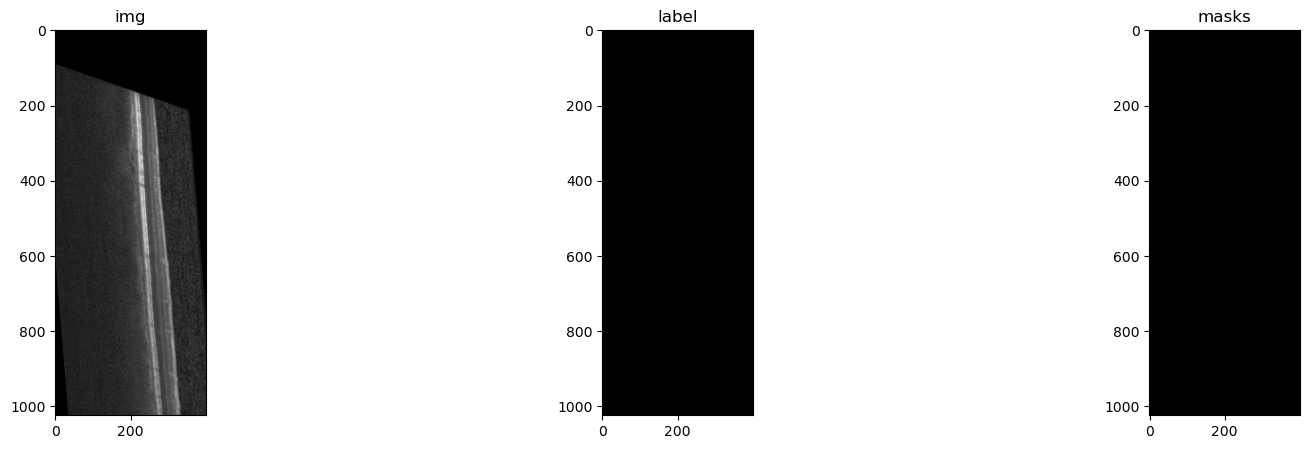

Sample 1 
Img:  torch.Size([1, 1024, 400]) 
Label:  torch.Size([1, 1024, 400]) 
Masks:  torch.Size([3, 1024, 400])


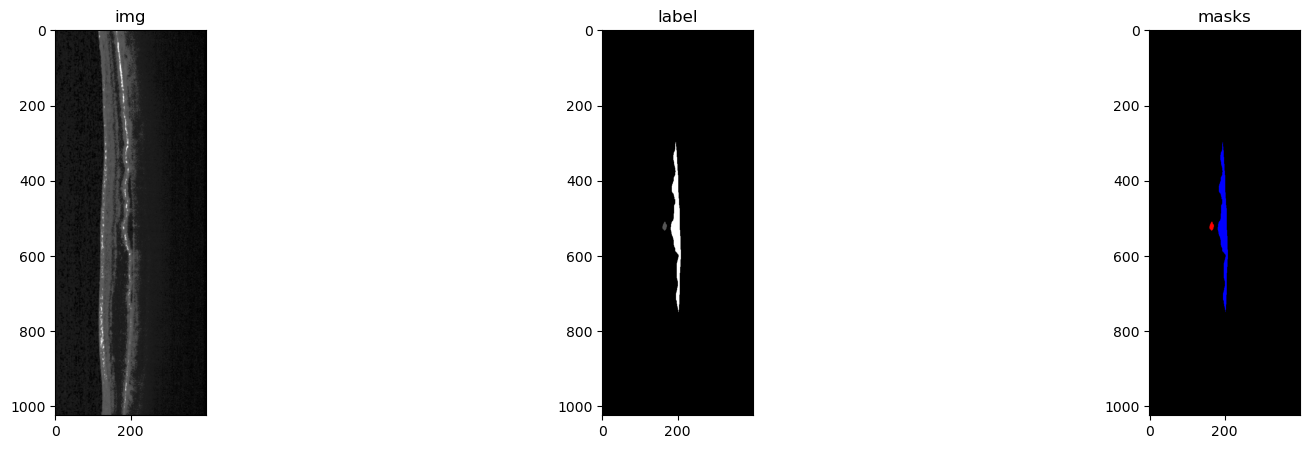

Sample 2 
Img:  torch.Size([1, 1024, 400]) 
Label:  torch.Size([1, 1024, 400]) 
Masks:  torch.Size([3, 1024, 400])


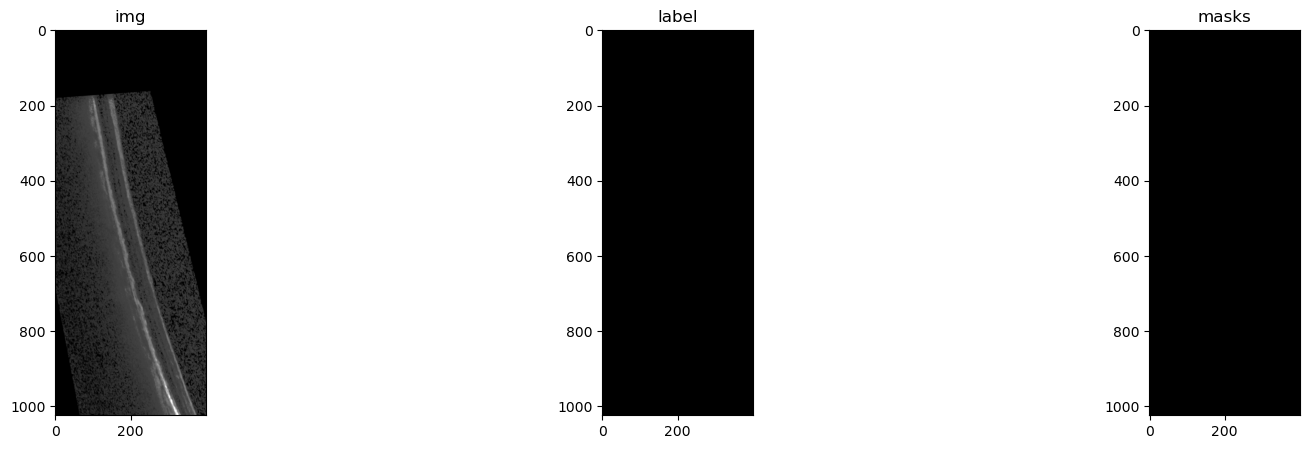

Sample 3 
Img:  torch.Size([1, 1024, 400]) 
Label:  torch.Size([1, 1024, 400]) 
Masks:  torch.Size([3, 1024, 400])


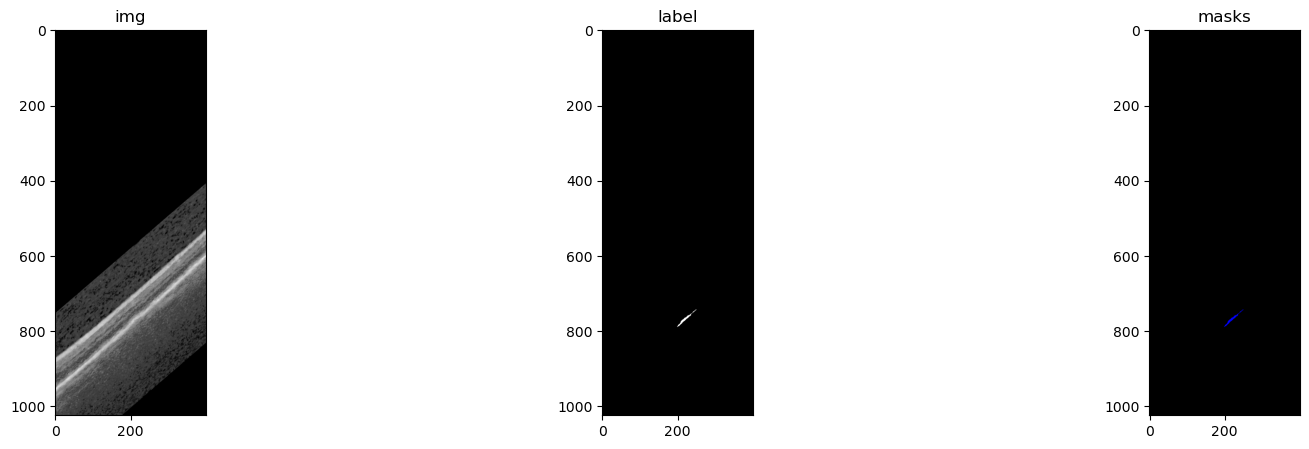

Sample 4 
Img:  torch.Size([1, 1024, 400]) 
Label:  torch.Size([1, 1024, 400]) 
Masks:  torch.Size([3, 1024, 400])


In [8]:
print_some_imgs = True

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir).get_datasets()
    train_data = MakeDataset(train_data_raw, transforms_visualize)
    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape, 
              "\nMasks: ", sample['masks'].shape)



## Architecture, dataset, loss function, optimizer

In [9]:
if not os.path.isdir('models'):
    os.mkdir('models')


print("Device: ", cfg.device)


model = monai.networks.nets.UNet(**cfg.model_parameters_unet)
#model = BasicUNetPlusPlus(**cfg.model_parameters_unetpp)


model = model.to(cfg.device)
criterion = monai.losses.DiceLoss(sigmoid=True)
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

# Prepare dataset
train_data, val_data, _ = OCTDatasetPrep(cfg.train_dir).get_datasets(dataset_split=[0.8, 0.2, 0.0])

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)


Device:  mps
Training set: 628
Validation set: 156
Test set: 0


## First tests

Let's overfit on a single batch of 16 images.
Then on two batches of 16 images.
Adapt the learning rate: 1e-4, 1e-3, 5e-3 

In [10]:
#model = load_model(model, cfg.model_path / 'model_two_batches.pth')

wandb_config = {
    'batch_size': cfg.batch_size,
    'lr': cfg.lr,
    'epochs': cfg.epochs,
    'device': cfg.device,
    'model': 'UNet',
    'dataset': 'Retouch',
    'model_parameters': cfg.model_parameters_unet,
}

with wandb.init(project='PracticalWorkinAI', 
                config=wandb_config,
                name='First run with all augmentations and Unet') as run:
    wandb_config = wandb.config
    
    model = train(model, 
                train_loader, val_loader, 
                criterion, optimizer, cfg.device, 
                epochs=cfg.epochs, 
                save_path= cfg.model_path / 'model.pth')

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

In [48]:
def plot_img_label_pred(img, label, pred, mask, device):
    fig, ax = plt.subplots(1, 3, figsize=(6, 12))
    
    img = img.squeeze().cpu().detach().numpy()
    label = label.squeeze().cpu().detach().numpy()
    pred = pred.squeeze().permute(1,2,0).cpu().detach().numpy()
    mask = mask.squeeze().permute(1,2,0).cpu().detach().numpy()

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(pred, cmap='gray')
    ax[1].set_title('Prediction')
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title('Ground Truth')
    plt.show()

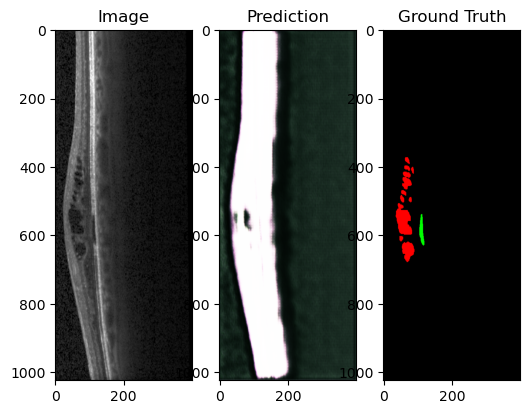

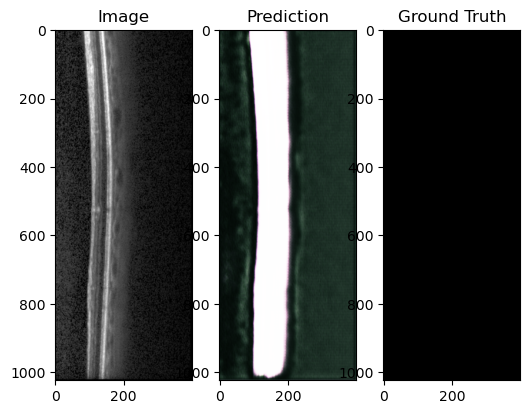

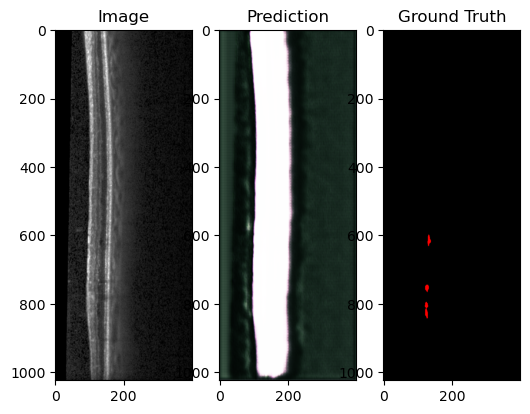

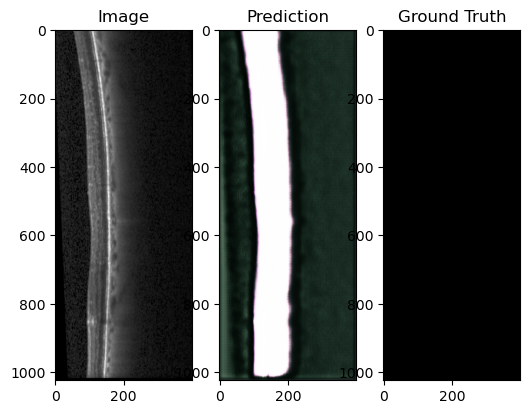

In [49]:
# load saved model and make predictions on random images from the validation set
model = load_model(model, cfg.model_path / 'model.pth')
model.eval()

for i in range(4):
    rand_num = np.random.randint(0, len(val_dataset))
    sample = val_dataset[rand_num]
    img = sample['img'].unsqueeze(0).to(cfg.device)
    label = sample['label'].unsqueeze(0).to(cfg.device)
    mask = sample['masks'].unsqueeze(0).to(cfg.device)
    pred = model(img)
    pred = torch.sigmoid(pred)

    plot_img_label_pred(img, label, pred, mask, cfg.device)